In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [3]:
using SciMLSensitivity

In [4]:
solver_args = Dict(:adaptive => false, 
                    :dt => 0.01,
                    :sensealg => InterpolatingAdjoint(; autojacvec=ZygoteVJP()),
                    :save_start => true)

Dict{Symbol, Any} with 4 entries:
  :adaptive   => false
  :sensealg   => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(Zygote…
  :dt         => 0.01
  :save_start => true

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage=-0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [7]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [8]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [12]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), 
                x -> tanh_fast.(x), 
                x -> x, 
                PhasorDenseF32(2 => 128), 
                x -> x,
                PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

build_mlp_f32 (generic function with 1 method)

In [13]:
function build_ode_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)),
                x -> tanh_fast.(x),
                x -> phase_to_current(x, spk_args=spk_args, tspan=(0.0, 10.0)),
                PhasorDenseF32(2 => 128, return_solution=true),
                x -> mean_phase(x, 1, spk_args=spk_args, offset=0.0),
                PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_ode_mlp_f32 (generic function with 1 method)

In [16]:
ode_model, ps_ode, st_ode = build_ode_mlp_f32(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{:direct_call, var"#39#42"}, layer_3::WrappedFunction{:direct_call, var"#40#43"{SpikingArgs}}, layer_4::PhasorDenseF32, layer_5::WrappedFunction{:direct_call, var"#41#44"{SpikingArgs}}, layer_6::PhasorDenseF32}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction{:direct_call}(var"#39#42"()), layer_3 = WrappedFunction{:direct_call}(var"#40#43"{SpikingArgs}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
)), layer_4 = PhasorDenseF32((2, 128)), layer_5 = WrappedFunction{:direct_call}(var"#41#44"{SpikingArgs}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
)), layer_6 = PhasorDenseF32((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (w

In [18]:
y_f, _ = model(x, ps, st)

([-0.020149648238458575 0.045700038069459076 … 0.014530519942781352 0.011981539154404282; -0.02249536798937414 -0.009955395182095284 … -0.05483856973419426 -0.02312620330193895], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [19]:
yfn, _ = front_model(x, ps_front, st_front)

(CurrentCall(LocalCurrent(Main.PhasorNetworks.var"#inner#81"{SpikingArgs, Float64, Matrix{Float64}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0, [0.9711341735396107 -0.1628081753962095 … -0.1339564920906035 -0.07084449409788965; -0.7382633272485227 0.8960409235587877 … -0.39980853999123117 -0.08884499833474777]), (2, 256), 0.0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [20]:
ps |> keys

(:layer_1, :layer_2, :layer_3, :layer_4, :layer_5, :layer_6)

In [21]:
y_ode, _ = ode_model(x, ps, st)

([-0.018581063476780253 0.04713840168016965 … 0.013608577294612382 0.012103017676270996; -0.025152750586505335 -0.011296784172067474 … -0.05703657322914898 -0.023492370554897335], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

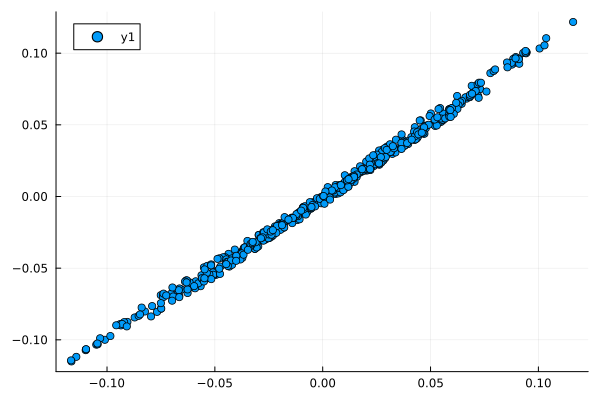

In [22]:
scatter(vec(y_f), vec(y_ode))

In [23]:
cor_realvals(vec(y_f), vec(y_ode))

0.9979981712913386

In [24]:
y_ode

2×256 Matrix{Float64}:
 -0.0185811   0.0471384  -0.0685734    0.0170443  …   0.0136086   0.012103
 -0.0251528  -0.0112968  -0.00751247  -0.0257744     -0.0570366  -0.0234924

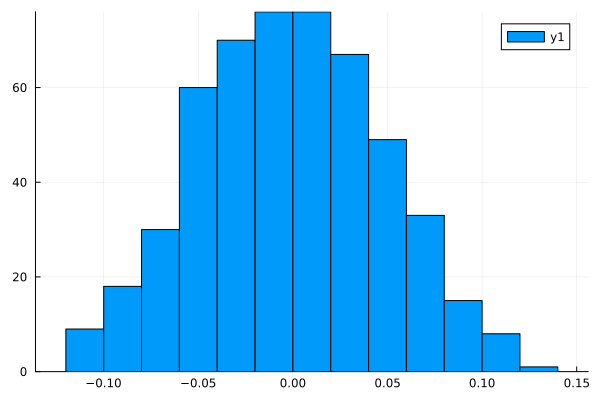

In [25]:
histogram(vec(y_ode))

In [26]:
mean(abs.(y_ode))

0.03945110407492

In [27]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = Float32[], layer_6 = (weight = Float32[0.022885242 -0.20376815 … 0.006069808 0.04844268; 0.22680388 0.0039727697 … -0.09966416 -0.19447207], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [29]:
val_ode, grads_ode = withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 1.471662355191007, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.009551919 -0.0030681877; -0.089284964 0.012273973; … ; 0.0025404114 -0.00014623287; 0.01796567 -0.005354513], bias_real = Float32[-0.002424956, -0.0045171967, 0.027120396, 0.0007290213, 0.005727287, -0.00065148296, 0.008294319, -0.007893111, -0.00013383657, -0.004801385  …  0.00019704032, 0.00038831806, -0.007312015, 0.0040992233, -0.000664254, 0.0006615429, -0.009839914, 0.0007666467, 9.676452f-5, -0.00018054093], bias_imag = Float32[-0.077634275, 0.2442062, -0.32211107, 0.007849192, 0.16090706, 0.01120041, -0.1746109, 0.14844878, 0.11036988, -0.048013568  …  -0.016659316, -0.0977905, 0.15287079, 0.0941168, 0.04591056, 0.040634464, 0.18766122, 0.009196561, 0.015502293, -0.0031981266]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.38660482 -0.478195 … -0.47590938 -0.46116245; 0.00041048654 0.000991634 … 5.

In [30]:
val, grads = withgradient(p -> mean(quadrature_loss(model(x, p, st_ode)[1], y)), psf)

(val = 1.4706037375638648, grad = ((layer_1 = (bias = [0.11004545539617538; -0.7869316935539246;;], scale = [-0.001492134350702237; 0.08974710932052637;;]), layer_2 = Float64[], layer_3 = Float64[], layer_4 = (weight = [0.005294011440128088 -0.006110131740570068; -0.08711883425712585 0.012018236331641674; … ; 0.0030810360331088305 0.0005020728567615151; 0.018876656889915466 -0.003793502226471901], bias_real = [-0.0009091846295632422, -0.004436491522938013, 0.0264485701918602, 0.0006604988593608141, 0.005613714922219515, -0.0005188493523746729, 0.008129284717142582, -0.007794192526489496, 4.590681055560708e-5, -0.004703197628259659  …  0.00019024021457880735, 0.0010075938189402223, -0.007184620480984449, 0.004090155474841595, -0.0006492491229437292, 0.0006380418781191111, -0.00948100071400404, 0.0008878207881934941, 0.00013726018369197845, -0.00015219382476061583], bias_imag = [-0.07791613042354584, 0.24256569147109985, -0.32087409496307373, 0.007933436892926693, 0.159660205245018, 0.01

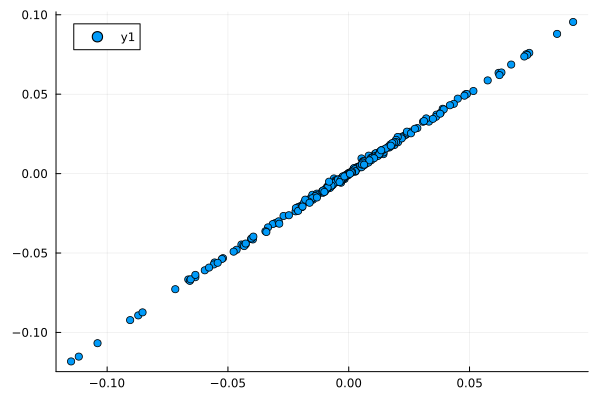

In [31]:
scatter(vec(grads[1].layer_4.weight), vec(grads_ode[1].layer_4.weight))

In [32]:
cor_realvals(vec(grads[1].layer_4.weight), vec(grads_ode[1].layer_4.weight))

0.9995846165597823

In [33]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.49872121134692143, 0.5211221973435561, 0.5082742474195519, 0.5136231831737799, 0.4943845354082511, 0.49740236463324033, 0.4872463266986948, 0.481221219549921, 0.48914629204794935, 0.4815789206296046  …  0.0568530273633278, 0.04347768528300689, 0.045888754199539736, 0.04510184537587257, 0.061042395060813236, 0.049483366029535035, 0.054607927545205576, 0.05410345407506266, 0.06503692399941924, 0.05217629091596032], (layer_1 = (bias = Float32[-0.19684447; -0.19686742;;], scale = Float32[0.81389666; 0.8042378;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.04173581 0.011097611; 0.007310995 -0.098167986; … ; 0.15090613 -0.018089933; -0.24436979 0.022904145], bias_real = Float32[0.9893609, 1.0206473, 1.0272624, 0.9854006, 0.8565414, 0.9733166, 0.9726222, 0.98102, 0.9935856, 0.97464263  …  0.9867618, 1.0006989, 1.0331075, 1.020813, 0.98554134, 1.0059948, 0.9812722, 0.9916397, 1.0107608, 0.9958822], bias_imag = Float32[-0.0050614476, -0.0040287124, 0.0

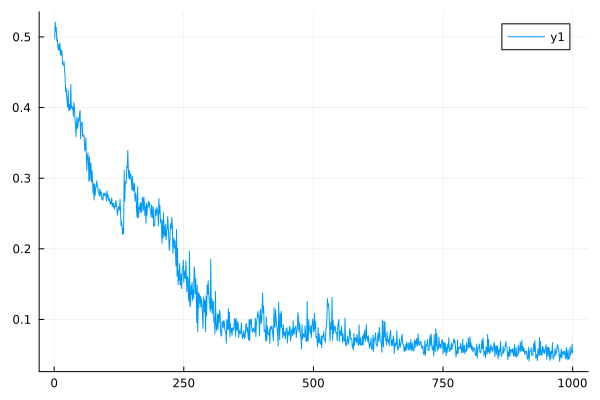

In [34]:
plot(losses)

In [35]:
losses[end]

0.05217629091596032

In [36]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.05066728205196651, 0.973828125)

In [37]:
psf = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = Float32[], layer_6 = (weight = Float32[0.12666641 -0.120561965 … -0.12208452 -0.13078421; -0.04557358 -0.05778698 … -0.0043423125 0.09756272], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [38]:
losses_ode, ps_train_ode, st_train_ode = train(ode_model, psf, st, train_loader, args, verbose = true)

[ Info: Training on CPU


Epoch 1 loss: 0.5005519728243485
Epoch 1 loss: 0.523479248923468
Epoch 1 loss: 0.5104489272578225
Epoch 1 loss: 0.5164714930745192
Epoch 1 loss: 0.4961919495619095
Epoch 1 loss: 0.49959461342513767
Epoch 1 loss: 0.48881698710100485
Epoch 1 loss: 0.4826798871242402
Epoch 1 loss: 0.491422594234397
Epoch 1 loss: 0.48319788815724835
Epoch 1 loss: 0.4939399355611974
Epoch 1 loss: 0.476729379020623
Epoch 1 loss: 0.4836309674909591
Epoch 1 loss: 0.4757967209619686
Epoch 1 loss: 0.4832422115501827
Epoch 1 loss: 0.46396408767007635
Epoch 1 loss: 0.464219757457725
Epoch 1 loss: 0.46284070399957755
Epoch 1 loss: 0.4696316734956312
Epoch 1 loss: 0.45725176422589986
Epoch 1 loss: 0.44905651796672424
Epoch 1 loss: 0.4267889648987937
Epoch 1 loss: 0.4328341607708437
Epoch 1 loss: 0.42503557229077915
Epoch 1 loss: 0.41514504468511654
Epoch 1 loss: 0.4030933310464685
Epoch 1 loss: 0.430135751457941
Epoch 1 loss: 0.4033681345508123
Epoch 1 loss: 0.41431871720787683
Epoch 1 loss: 0.40225396213992887
Epoc

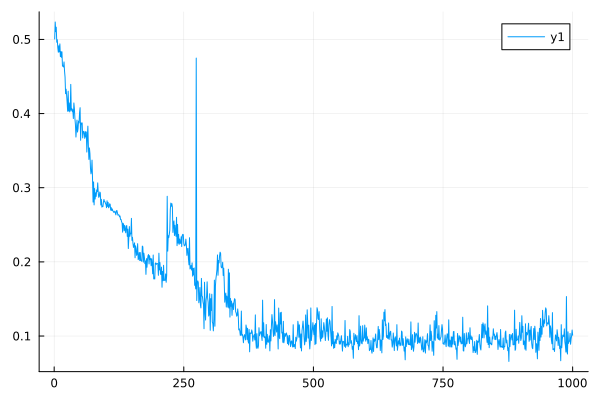

In [ ]:
plot(losses_ode)

In [ ]:
loss_and_accuracy(test_loader, ode_model, ps_train_ode, st_train_ode)

(0.1108247329922166, 0.96640625)

In [ ]:
#correlate phasor, ode, and spiking